In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list({ch for w in words for ch in w}))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [131]:
# build the dataset

block_size = 3 # context_length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [132]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
C = torch.randn((27, 2))

In [36]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [37]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [69]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [70]:
h.shape

torch.Size([32, 100])

In [72]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [85]:
logits = h @ W2 + b2

In [86]:
logits.shape

torch.Size([32, 27])

In [76]:
counts = logits.exp()

In [79]:
prob = counts / counts.sum(1, keepdims=True)

In [84]:
prob.shape

torch.Size([32, 27])

In [90]:
prob[0]

tensor([1.1523e-07, 2.1078e-07, 5.6146e-09, 1.8030e-16, 5.7856e-07, 1.4289e-08,
        9.3003e-13, 3.3187e-05, 1.5750e-01, 2.0782e-13, 8.0815e-11, 3.6969e-06,
        7.5109e-04, 2.3821e-06, 8.3872e-01, 1.0040e-06, 5.6304e-10, 2.9533e-08,
        4.0511e-04, 6.4319e-14, 2.4099e-03, 6.4143e-12, 1.7023e-10, 2.4156e-06,
        3.7785e-10, 2.7917e-14, 1.7247e-04])

In [95]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.4410)

In [96]:
# ---------------- Cleaning up the above code --------------

In [133]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [202]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [135]:
sum(p.nelement() for p in parameters) # num of param in total

3481

In [203]:
for p in parameters:
    p.requires_grad = True

In [194]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [205]:
lri = []
lossi = []

for i in range(10000):   
    # minibatch
    ix = torch.randint(0, X.shape[0], (32, ))
    
    # Forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # lri.append(lre[i]) 
    # lossi.append(loss.item())
    
print(loss.item()) # This is only the minibatch loss

2.3665833473205566


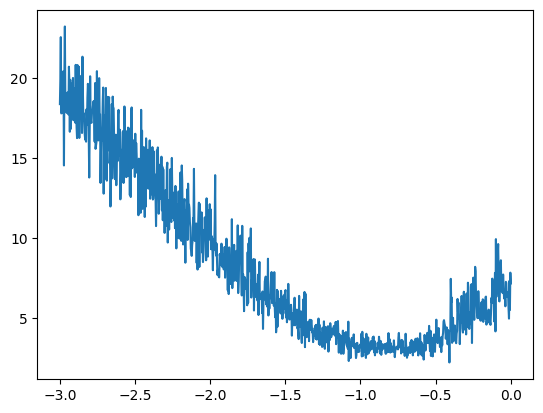

In [201]:
plt.plot(lri, lossi)

In [166]:
# Loss over all examples
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.5764243602752686
